In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as du
from matplotlib import pyplot as plt
import pandas as pd

This project attempts to seperate genuine and forged banknotes using logistic regresion. The dataset for this project is taken from *https://archive.ics.uci.edu/ml/datasets/banknote+authentication*. 

The curators of the dataset preprocessed 400 x 400 pixel banknote images using Wavelet Transformation to extract the following features: variance, skewness, curtosis, entopy.  

Since this task requires seperating banknotes into two categories, logistic regression will be the best algorithm for this task

In [2]:
'''
link to dataset: https://archive.ics.uci.edu/ml/datasets/banknote+authentication
'''
df = pd.read_csv("data_banknote_authentication.txt")
df

,3.6216,8.6661,-2.8073,-0.44699,0
0,4.54590,8.16740,-2.4586,-1.46210,0
1,3.86600,-2.63830,1.9242,0.10645,0
2,3.45660,9.52280,-4.0112,-3.59440,0
3,0.32924,-4.45520,4.5718,-0.98880,0
4,4.36840,9.67180,-3.9606,-3.16250,0
...,...,...,...,...,...
1366,0.40614,1.34920,-1.4501,-0.55949,1
1367,-1.38870,-4.87730,6.4774,0.34179,1
1368,-3.75030,-13.45860,17.5932,-2.77710,1
1369,-3.56370,-8.38270,12.3930,-1.28230,1


In [3]:
'''
for preprocessing, we must randomize the dataset so we get an even distribution of labels for training
and testing split
'''

df = df.sample(frac=1)
df

,3.6216,8.6661,-2.8073,-0.44699,0
1021,-0.66008,-3.22600,3.805800,1.18360,1
104,3.54380,1.23950,1.997000,2.15470,0
1117,-1.93890,1.57060,0.045979,-1.12200,1
257,3.74400,0.79459,0.958510,1.00770,0
993,-0.87340,1.65330,-2.196400,-0.78061,1
...,...,...,...,...,...
1211,-2.45600,-0.24418,1.404100,-0.45863,1
933,-1.61760,1.09260,-0.355020,-0.59958,1
312,2.12740,5.19390,-1.797100,-1.17630,0
790,-4.47790,7.37080,-0.312180,-6.77540,1


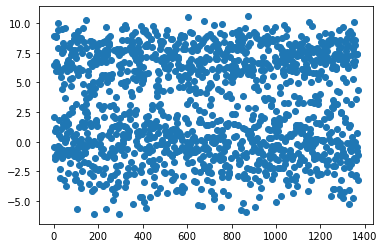

In [4]:
'''
By simply averaging each banknotes features, we can observe a binary split when plotting the points.
Based on this, we can confirm that the features given to us are good. 
'''
y = torch.from_numpy(df.values)
y = torch.sum(y, dim=1)
x = torch.arange(0, y.shape[0])
plt.scatter(x, y)

In [5]:
class LogisticRegression(nn.Module):
    def __init__(self, num_features, device = f"cuda:0"):
        super(LogisticRegression, self).__init__()
        '''
        binary classification using Logistic Regression,
        num_features = number of features
        '''
        self.w = nn.Parameter(torch.randn(num_features, 1, device = device), requires_grad=True)   # (n x 1)
        self.b = nn.Parameter(torch.randn(1,1, device = device), requires_grad=True)   # (1 x 1)
        self.n = num_features
    
    def sigmoid(self, a):
        '''
        custom sigmoid function
        '''
        return 1/(1+(torch.exp(-a)))
    
    def forward(self, X, Y):
        '''
        X is (batch_size x n)
        Y is (batch_size x 1)
        '''
        X = X.T # (n x batch_size)
        A = self.sigmoid(torch.matmul(self.w.T, X) + self.b)  # (1 x batch_size)
        return A.T

In [6]:
def loss_function(X, A, Y):
    '''
    cost function
    
    X = features,
    A = predicted labels,
    Y = actual labels
    '''
    X = X.T
    Y = Y.T
    A = A.T
    n = X.shape[0]
    cost = -torch.sum(Y*torch.log(A) + (1-Y)*torch.log(1-A))
    X = X.T
    Y = Y.T
    return cost 

def update_grad(X, A, Y, params):
    '''
    calculates/updates the gradient of the cost function

    X = features
    A = predicted labels,
    Y = actual labels
    '''
    w = next(params)
    b = next(params)
    X = X.T
    Y = Y.T
    A = A.T
    n = X.shape[0]
    cost = -torch.sum(Y*torch.log(A) + (1-Y)*torch.log(1-A))  # loss
    w.grad = torch.matmul(X, (A-Y).T) / n  # update gradient of weights, (n x 1)
    b.grad = (torch.sum(A-Y, dim=1).unsqueeze(dim=-1)) / n            # update gradient of bias, (1, 1)
    X = X.T
    Y = Y.T
    return cost 

def gradient_descent(params, learning_rate):
    '''
    performs updates the values of the weights and bias using vanilla gradient descent,
    params = learnable parameters of model
    '''
    with torch.no_grad():
        for p in params:
            p -= learning_rate * p.grad

In [7]:
device = f"cuda:0" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")
mini_batch_size = 64
num_features = df.shape[1] - 1
epochs = 20

vanilla_grad_model = LogisticRegression(num_features)
mini_batch_grad_model = LogisticRegression(num_features)
Adam_model = LogisticRegression(num_features)
RMSprop_model = LogisticRegression(num_features)


train_loader = du.DataLoader(dataset=torch.from_numpy(df[:df.shape[0]*8 // 10].values).float(),
                             batch_size=df.shape[0],  # batch_size is the length of the entire dataset
                             shuffle=True)
mini_batch_train_loader = du.DataLoader(dataset=torch.from_numpy(df[:df.shape[0]*8 // 10].values).float(),
                             batch_size=mini_batch_size,
                             shuffle=True)
test_loader = du.DataLoader(dataset=torch.from_numpy(df[df.shape[0]*8//10:].values).float(),
                             batch_size=df.shape[0],
                             shuffle=True)

Adam_optim = torch.optim.Adam(Adam_model.parameters(), lr=0.9)
RMSprop_optim = torch.optim.RMSprop(RMSprop_model.parameters(), lr=0.9)

# send model over to device
vanilla_grad_model = vanilla_grad_model.to(device)
mini_batch_grad_model = mini_batch_grad_model.to(device)
Adam_model = Adam_model.to(device)
RMSprop_model = RMSprop_model.to(device)
vanilla_grad_model.train() 
mini_batch_grad_model.train()
Adam_model.train() 
RMSprop_model.train()

using device: cuda:0


LogisticRegression()

The two variants of gradient descent I chose to implement are vanilla and minibatch gradient descent

In [8]:
'''
vanilla gradient descent 
'''

for epoch in range(1, epochs + 1):    
    correct = 0
    running_loss = 0
    for batch_idx, (data) in enumerate(train_loader):  # batch size is the whole dataset
        features, label = data[:,:num_features].to(device), data[:,num_features].unsqueeze(1).to(device)
        pred = vanilla_grad_model(features, label)
        running_loss += loss_function(features, pred, label)
        pred = torch.round(pred)
        correct += torch.sum(pred == label)
        update_grad(features, pred, label, vanilla_grad_model.parameters())
        gradient_descent(vanilla_grad_model.parameters(), 0.01)
    print(f"Epoch {epoch}, Training Accuracy: {correct / len(train_loader.dataset):.6f}, Training Loss = {running_loss / len(train_loader.dataset):.6f}")

test_correct = 0
test_running_loss = 0
vanilla_grad_model.eval()
with torch.no_grad():
    for batch_idx, (data) in enumerate(test_loader):
        features, label = data[:,:num_features].to(device), data[:,num_features].unsqueeze(1).to(device)
        pred = vanilla_grad_model(features, label)
        test_running_loss += loss_function(features, pred, label)
        pred = torch.round(pred)
        test_correct += torch.sum(pred == label)
print(f"Testing Accuracy: {test_correct / len(test_loader.dataset):.6f}, Testing Loss = {test_running_loss / len(test_loader.dataset):.6f}")

Epoch 1, Training Accuracy: 0.533759, Training Loss = 1.498998
Epoch 2, Training Accuracy: 0.493613, Training Loss = nan
Epoch 3, Training Accuracy: 0.662409, Training Loss = nan
Epoch 4, Training Accuracy: 0.820255, Training Loss = nan
Epoch 5, Training Accuracy: 0.924270, Training Loss = nan
Epoch 6, Training Accuracy: 0.935219, Training Loss = nan
Epoch 7, Training Accuracy: 0.952555, Training Loss = nan
Epoch 8, Training Accuracy: 0.953467, Training Loss = nan
Epoch 9, Training Accuracy: 0.956204, Training Loss = nan
Epoch 10, Training Accuracy: 0.959854, Training Loss = nan
Epoch 11, Training Accuracy: 0.960766, Training Loss = nan
Epoch 12, Training Accuracy: 0.961679, Training Loss = nan
Epoch 13, Training Accuracy: 0.964416, Training Loss = nan
Epoch 14, Training Accuracy: 0.967153, Training Loss = nan
Epoch 15, Training Accuracy: 0.960766, Training Loss = nan
Epoch 16, Training Accuracy: 0.970803, Training Loss = nan
Epoch 17, Training Accuracy: 0.962591, Training Loss = nan
E

In [9]:
'''
mini batch gradient descent 
'''

for epoch in range(1, epochs + 1):    
    correct = 0
    running_loss = 0
    for batch_idx, (data) in enumerate(mini_batch_train_loader): # batch size is 64
        features, label = data[:,:num_features].to(device), data[:,num_features].unsqueeze(1).to(device)
        pred = mini_batch_grad_model(features, label)
        running_loss += loss_function(features, pred, label)
        pred = torch.round(pred)
        correct += torch.sum(pred == label)
        update_grad(features, pred, label, mini_batch_grad_model.parameters())
        gradient_descent(mini_batch_grad_model.parameters(), 0.01)
    print(f"Epoch {epoch}, Training Accuracy: {correct / len(train_loader.dataset):.6f}, Training Loss = {running_loss / len(train_loader.dataset):.6f}")

test_correct = 0
test_running_loss = 0
mini_batch_grad_model.eval()
with torch.no_grad():
    for batch_idx, (data) in enumerate(test_loader):
        features, label = data[:,:num_features].to(device), data[:,num_features].unsqueeze(1).to(device)
        pred = mini_batch_grad_model(features, label)
        test_running_loss += loss_function(features, pred, label)
        pred = torch.round(pred)
        test_correct += torch.sum(pred == label)
print(f"Testing Accuracy: {test_correct / len(test_loader.dataset):.6f}, Testing Loss = {test_running_loss / len(test_loader.dataset):.6f}")

Epoch 1, Training Accuracy: 0.548358, Training Loss = 1.246037
Epoch 2, Training Accuracy: 0.856752, Training Loss = 0.343368
Epoch 3, Training Accuracy: 0.917883, Training Loss = 0.301203
Epoch 4, Training Accuracy: 0.947993, Training Loss = 0.301754
Epoch 5, Training Accuracy: 0.958942, Training Loss = 0.302638
Epoch 6, Training Accuracy: 0.965328, Training Loss = 0.307640
Epoch 7, Training Accuracy: 0.964416, Training Loss = 0.298790
Epoch 8, Training Accuracy: 0.969890, Training Loss = 0.299879
Epoch 9, Training Accuracy: 0.977190, Training Loss = 0.298300
Epoch 10, Training Accuracy: 0.979927, Training Loss = 0.299355
Epoch 11, Training Accuracy: 0.986314, Training Loss = 0.306577
Epoch 12, Training Accuracy: 0.978102, Training Loss = 0.305263
Epoch 13, Training Accuracy: 0.979927, Training Loss = 0.300408
Epoch 14, Training Accuracy: 0.977190, Training Loss = 0.298215
Epoch 15, Training Accuracy: 0.977190, Training Loss = 0.294586
Epoch 16, Training Accuracy: 0.982664, Training L

Using torch.optim package to implement Adam and RMSprop 

In [10]:
'''
Adam Optimizer
'''

for epoch in range(1, epochs + 1):    
    correct = 0
    running_loss = 0
    for batch_idx, (data) in enumerate(train_loader):
        Adam_optim.zero_grad()
        features, label = data[:,:num_features].to(device), data[:,num_features].unsqueeze(1).to(device)
        pred = Adam_model(features, label)
        running_loss += loss_function(features, pred, label)
        pred = torch.round(pred)
        correct += torch.sum(pred == label)
        update_grad(features, pred, label, Adam_model.parameters())
        Adam_optim.step()
    print(f"Epoch {epoch}, Training Accuracy: {correct / len(train_loader.dataset):.6f}, Training Loss = {running_loss / len(train_loader.dataset):.6f}")

test_correct = 0
test_running_loss = 0
Adam_model.eval()
with torch.no_grad():
    for batch_idx, (data) in enumerate(test_loader):
        features, label = data[:,:num_features].to(device), data[:,num_features].unsqueeze(1).to(device)
        pred = Adam_model(features, label)
        test_running_loss += loss_function(features, pred, label)
        pred = torch.round(pred)
        test_correct += torch.sum(pred == label)
print(f"Testing Accuracy: {test_correct / len(test_loader.dataset):.6f}, Testing Loss = {test_running_loss / len(test_loader.dataset):.6f}")

Epoch 1, Training Accuracy: 0.241788, Training Loss = inf
Epoch 2, Training Accuracy: 0.455292, Training Loss = 1.976119
Epoch 3, Training Accuracy: 0.613139, Training Loss = nan
Epoch 4, Training Accuracy: 0.673358, Training Loss = nan
Epoch 5, Training Accuracy: 0.780109, Training Loss = nan
Epoch 6, Training Accuracy: 0.819343, Training Loss = nan
Epoch 7, Training Accuracy: 0.844890, Training Loss = nan
Epoch 8, Training Accuracy: 0.854015, Training Loss = nan
Epoch 9, Training Accuracy: 0.883212, Training Loss = nan
Epoch 10, Training Accuracy: 0.896898, Training Loss = nan
Epoch 11, Training Accuracy: 0.912409, Training Loss = nan
Epoch 12, Training Accuracy: 0.920620, Training Loss = nan
Epoch 13, Training Accuracy: 0.935219, Training Loss = nan
Epoch 14, Training Accuracy: 0.952555, Training Loss = nan
Epoch 15, Training Accuracy: 0.960766, Training Loss = nan
Epoch 16, Training Accuracy: 0.971715, Training Loss = nan
Epoch 17, Training Accuracy: 0.971715, Training Loss = nan
E

In [11]:
'''
RMSprop Optimizer
'''

for epoch in range(1, epochs + 1):    
    correct = 0
    running_loss = 0
    for batch_idx, (data) in enumerate(train_loader):
        RMSprop_optim.zero_grad()
        features, label = data[:,:num_features].to(device), data[:,num_features].unsqueeze(1).to(device)
        pred = RMSprop_model(features, label)
        running_loss += loss_function(features, pred, label)
        pred = torch.round(pred)
        correct += torch.sum(pred == label)
        update_grad(features, pred, label, RMSprop_model.parameters())
        RMSprop_optim.step()
    print(f"Epoch {epoch}, Training Accuracy: {correct / len(train_loader.dataset):.6f}, Training Loss = {running_loss / len(train_loader.dataset):.6f}")

test_correct = 0
test_running_loss = 0
RMSprop_model.eval()
with torch.no_grad():
    for batch_idx, (data) in enumerate(test_loader):
        features, label = data[:,:num_features].to(device), data[:,num_features].unsqueeze(1).to(device)
        pred = RMSprop_model(features, label)
        test_running_loss += loss_function(features, pred, label)
        pred = torch.round(pred)
        test_correct += torch.sum(pred == label)
print(f"Testing Accuracy: {test_correct / len(test_loader.dataset):.6f}, Testing Loss = {test_running_loss / len(test_loader.dataset):.6f}")

Epoch 1, Training Accuracy: 0.464416, Training Loss = 1.440198
Epoch 2, Training Accuracy: 0.647810, Training Loss = nan
Epoch 3, Training Accuracy: 0.797445, Training Loss = nan
Epoch 4, Training Accuracy: 0.873175, Training Loss = nan
Epoch 5, Training Accuracy: 0.918796, Training Loss = nan
Epoch 6, Training Accuracy: 0.945255, Training Loss = nan
Epoch 7, Training Accuracy: 0.958029, Training Loss = nan
Epoch 8, Training Accuracy: 0.968978, Training Loss = nan
Epoch 9, Training Accuracy: 0.979015, Training Loss = nan
Epoch 10, Training Accuracy: 0.970803, Training Loss = nan
Epoch 11, Training Accuracy: 0.983577, Training Loss = nan
Epoch 12, Training Accuracy: 0.985401, Training Loss = nan
Epoch 13, Training Accuracy: 0.987226, Training Loss = nan
Epoch 14, Training Accuracy: 0.987226, Training Loss = nan
Epoch 15, Training Accuracy: 0.982664, Training Loss = nan
Epoch 16, Training Accuracy: 0.986314, Training Loss = nan
Epoch 17, Training Accuracy: 0.985401, Training Loss = nan
E

When we compare the accuracy of the Adam and RMSprop optimizers, we will find that RMSprop converges faster than Adam. After 50 epochs, RMSprop yields an accuracy of 99.6% while Adam yields an accuracy of 96.4%

After 50 epochs, the testing accuracy of RMSprop is 99.6%, accuracy of Adam is 96.4%, the accuracy of Mini batch gradient descent is 98.9%, and the accuracy of vanilla gradient descent is 96.4%. While the accuracy of Adam is lower than mini batch gradient descent, the training accuracy of both optimizers oscillated less than both variants of gradient descent. Therefore, optimization algorithms should be used for this task since it yelds more stable training and let us use higher learning rates.   